In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [3]:
%%time
cluster_df = pd.read_table('../data3/interim/refseq_cover_clusters.tsv', 
                               names=['cluster_id', 'seq_id'])

CPU times: user 1min 15s, sys: 7.33 s, total: 1min 22s
Wall time: 1min 23s


In [4]:
%%time
seq_df = pd.read_parquet('../data/interim/refseq_seq_ids.pq')

CPU times: user 1min 8s, sys: 44.5 s, total: 1min 53s
Wall time: 2min 23s


In [5]:
cluster_counts = (cluster_df['cluster_id'].value_counts()
                  .reset_index())
cluster_counts

,cluster_id,count
0,2b6d60fa3b9344da23d70483294c92607dd09562cb4287...,61157
1,be95e77828f084e9e15747803bd14aef925d54f8a914b7...,60031
2,710e11d2089e120350289ecb9e18744ee4c648d255a3e2...,59613
3,fc7c606481814a96f84936fda5be9ee7b57f4ec38a2e4d...,54866
4,3fecb0a70fa67152e00b79c756827c7626428cc5d390b3...,52570
...,...,...
5053433,b95338d999d9b7e7188d3a38782834f2c2ea0675c2185f...,1
5053434,9b4a9718e1931f13f2256f635dfa7470375f5bcd985182...,1
5053435,31c6c555f0e037c156abd70ad48422a992092845545db5...,1
5053436,5e140febb1d6050576667496dbe0444499c68c6bdd6e62...,1


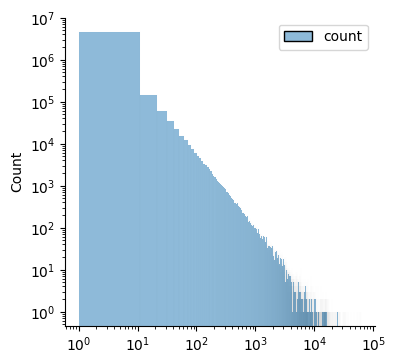

In [6]:
plt.subplots(figsize=(4,4))
sns.histplot(data=cluster_counts, binwidth=10)
sns.despine()
plt.xscale('log')
plt.yscale('log')

In [7]:
select_cluster_seqs = cluster_counts[['cluster_id']]
len(select_cluster_seqs)

5053438

In [8]:
minimal_seq_df = seq_df[seq_df['seq_id'].isin(select_cluster_seqs['cluster_id'])]

In [9]:
minimal_seq_f = '../data3/interim/minimal_seqs.faa'

In [10]:
with open(minimal_seq_f, 'w') as f:
    for _, row in tqdm(minimal_seq_df.iterrows(), total=len(minimal_seq_df)):
        print('>' + row['seq_id'], file=f)
        print(row['seq'], file=f)

100%|██████████| 5053438/5053438 [04:21<00:00, 19332.08it/s]


In [14]:
mmseqs_dir = '../data3/interim/mmseqs_dbs'
if not os.path.exists(mmseqs_dir):
    os.mkdir(mmseqs_dir)

In [15]:
minimal_seq_db = os.path.join(mmseqs_dir, 'minimal_seqs')

In [17]:
os.system(' '.join(['conda run -n beaker',
                    'mmseqs createdb',
                    minimal_seq_f,
                    minimal_seq_db]))

createdb ../data3/interim/minimal_seqs.faa ../data3/interim/mmseqs_dbs/minimal_seqs 

MMseqs Version:       	13.45111
Database type         	0
Shuffle input database	true
Createdb mode         	0
Write lookup file     	1
Offset of numeric ids 	0
Compressed            	0
Verbosity             	3

Converting sequences
[===================================================================================================	1 Mio. sequences processed
===================================================================================================	2 Mio. sequences processed
===================================================================================================	3 Mio. sequences processed
===================================================================================================	4 Mio. sequences processed
===================================================================================================	5 Mio. sequences processed
=====
Time for merging to minimal_seqs_h: 0h 0

0

In [18]:
os.system(' '.join(['conda run -n beaker',
                    'mmseqs createindex', 
                    minimal_seq_db,
                    '$TMPDIR']))

createindex ../data3/interim/mmseqs_dbs/minimal_seqs /state/partition1/slurm_tmp/1048662.0.0 

MMseqs Version:          	13.45111
Seed substitution matrix 	nucl:nucleotide.out,aa:VTML80.out
k-mer length             	0
Alphabet size            	nucl:5,aa:21
Compositional bias       	1
Max sequence length      	65535
Max results per query    	300
Mask residues            	1
Mask lower case residues 	0
Spaced k-mers            	1
Spaced k-mer pattern     	
Sensitivity              	7.5
k-score                  	0
Check compatible         	0
Search type              	0
Split database           	0
Split memory limit       	0
Verbosity                	3
Threads                  	96
Min codons in orf        	30
Max codons in length     	32734
Max orf gaps             	2147483647
Contig start mode        	2
Contig end mode          	2
Orf start mode           	1
Forward frames           	1,2,3
Reverse frames           	1,2,3
Translation table        	1
Translate orf            	0
Use all table

0

In [8]:
cluster_df.to_parquet('../data3/interim/refseq_cover_clusters.pq', index=False)
select_cluster_seqs.to_csv('../data3/interim/refseq_minimal_seq_ids.pq', index=False)